In [24]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import optuna

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold

## Read data

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
train.drop(columns=['id'], axis=1, inplace=True)
test.drop(columns=['id'], axis=1, inplace=True)

## Preprocess data

In [11]:
encoder = LabelEncoder()
scaler = MinMaxScaler()

train['Sex'] = encoder.fit_transform(train['Sex'])
test['Sex'] = encoder.transform(test['Sex'])

cat_cols = ['Sex']
continuous_cols = [col for col in train.columns if col not in cat_cols]

train[continuous_cols] = scaler.fit_transform(train[continuous_cols])
test[continuous_cols] = scaler.transform(test[continuous_cols])

X = train.drop(columns=['Rings'], axis=1).values
y = train['Rings'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.27, random_state=24)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape y_train to have shape (batch_size, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1) 

## Define network

In [12]:
class NODEModel(nn.Module):
    """
    Neural Oblivious Decision Ensembles (NODE) model.
    """
    def __init__(self, input_dim, num_trees, depth):
        """
        Initialize the NODE model.
        
        Args:
            input_dim (int): Number of input features.
            num_trees (int): Number of decision trees in the ensemble.
            depth (int): Depth of each decision tree.
        """
        super(NODEModel, self).__init__()
        self.num_trees = num_trees
        self.depth = depth
        
        # Create a list of decision trees
        self.trees = nn.ModuleList([nn.Sequential(
            nn.Linear(input_dim, 2 ** depth),
            nn.ReLU(),
            nn.Linear(2 ** depth, 1)
        ) for _ in range(num_trees)])
    
    def forward(self, x):
        """
        Perform forward pass through the NODE model.
        
        Args:
            x (torch.Tensor): Input tensor.
            
        Returns:
            torch.Tensor: Averaged predictions from all decision trees.
        """
        # Forward pass through each decision tree
        outputs = [tree(x) for tree in self.trees]
        
        # Average the predictions from all trees
        return torch.mean(torch.stack(outputs), dim=0)


## Define early stopper

In [19]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [20]:
# Define hyperparameters
input_dim = X_train.shape[1]  # Number of features
num_trees = 5
depth = 3
learning_rate = 0.001
num_epochs = 50
batch_size = 64

# Initialize the model
model = NODEModel(input_dim, num_trees, depth)

## Define training loop

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.0087, Val Loss: 0.0062
Epoch [2/50], Train Loss: 0.0057, Val Loss: 0.0052
Epoch [3/50], Train Loss: 0.0052, Val Loss: 0.0050
Epoch [4/50], Train Loss: 0.0050, Val Loss: 0.0049
Epoch [5/50], Train Loss: 0.0050, Val Loss: 0.0049
Epoch [6/50], Train Loss: 0.0049, Val Loss: 0.0048
Epoch [7/50], Train Loss: 0.0049, Val Loss: 0.0048
Epoch [8/50], Train Loss: 0.0048, Val Loss: 0.0048
Epoch [9/50], Train Loss: 0.0048, Val Loss: 0.0048
Epoch [10/50], Train Loss: 0.0048, Val Loss: 0.0048
Epoch [11/50], Train Loss: 0.0047, Val Loss: 0.0047
Epoch [12/50], Train Loss: 0.0047, Val Loss: 0.0047
Epoch [13/50], Train Loss: 0.0047, Val Loss: 0.0047
Epoch [14/50], Train Loss: 0.0047, Val Loss: 0.0047
Epoch [15/50], Train Loss: 0.0047, Val Loss: 0.0047
Epoch [16/50], Train Loss: 0.0047, Val Loss: 0.0047
Epoch [17/50], Train Loss: 0.0047, Val Loss: 0.0047
Epoch [18/50], Train Loss: 0.0047, Val Loss: 0.0047
Epoch [19/50], Train Loss: 0.0047, Val Loss: 0.0047
Epoch [20/50], Train 

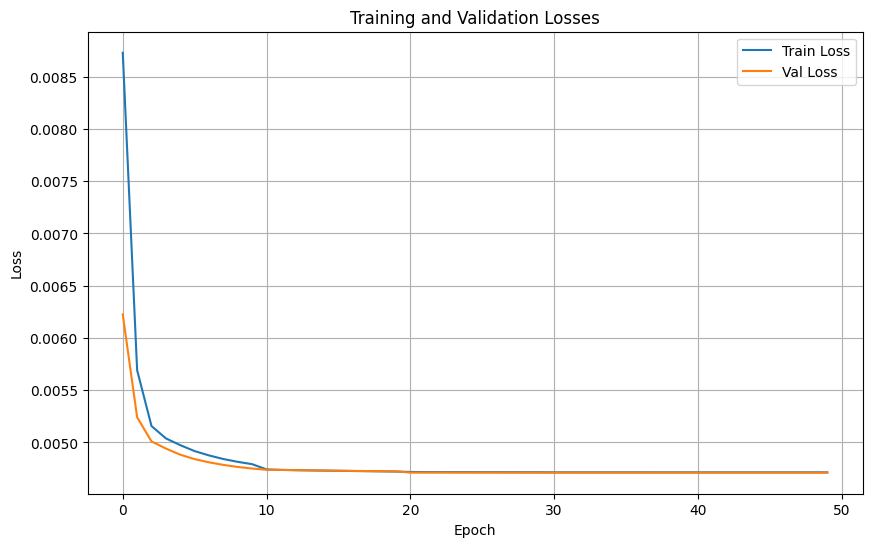

In [21]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store losses
train_losses = []
val_losses = []

# Define learning rate scheduler
scheduler_step_size = 10  # Adjust the learning rate every 10 epochs
scheduler_gamma = 0.1  # Reduce the learning rate by a factor of 0.1
scheduler = StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

# Define early stopper
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

# Training loop with tqdm
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()  # Set the model to training mode
    running_train_loss = 0.0
    
    # Mini-batch training
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        labels = y_train_tensor[i:i+batch_size]
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    train_loss = running_train_loss / len(X_train_tensor)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    val_losses.append(val_loss.item())
    
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Step the learning rate scheduler
    scheduler.step()
    
    # Check for early stopping
    if early_stopper.early_stop(val_loss):
        tqdm.write("Early stopping triggered.")
        break

print('Training finished.')

# Create DataFrame for losses
losses_df = pd.DataFrame({'Train Loss': train_losses, 'Val Loss': val_losses})

plt.figure(figsize=(10, 6))
plt.plot(losses_df['Train Loss'], label='Train Loss')
plt.plot(losses_df['Val Loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

## Inference

In [23]:
# Inference

test_tensor = torch.tensor(test.values, dtype=torch.float32)
with torch.no_grad():
    model.eval()
    predictions = model(test_tensor)
predictions

tensor([[0.4303],
        [0.4366],
        [0.4613],
        ...,
        [0.5739],
        [0.6567],
        [0.3943]])

## Hyperparameter tune 

In [ ]:
# Define your train_model function
def train_model(train_X, train_y, params):
    """
    Train the NODE model with the given hyperparameters.
    
    Args:
        train_X (torch.Tensor): Input training data.
        train_y (torch.Tensor): Target training data.
        params (dict): Hyperparameters for the model.
        
    Returns:
        float: Average validation RMSE across folds.
    """
    # Unpack the hyperparameters
    input_dim = train_X.shape[1]
    num_trees = params['num_trees']
    depth = params['depth']
    num_epochs = 35 
    batch_size = params['batch_size']
    
    # Set the device (GPU if available, else CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create the NODE model
    model = NODEModel(input_dim, num_trees, depth).to(device)
    
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Create KFold cross-validator
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    val_rmse_folds = []
    
    # Perform k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_X)):
        # Split data into train and validation sets
        X_train_fold, X_val_fold = train_X[train_idx], train_X[val_idx]
        y_train_fold, y_val_fold = train_y[train_idx], train_y[val_idx]
        
        # Convert data to PyTorch tensors
        X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32).view(-1, 1).to(device)
        X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val_fold, dtype=torch.float32).view(-1, 1).to(device)
        
        # Train the model
        for epoch in range(num_epochs):
            model.train()  # Set the model to training mode
            running_loss = 0.0
            
            # Mini-batch training
            for i in range(0, len(X_train_tensor), batch_size):
                inputs = X_train_tensor[i:i+batch_size]
                labels = y_train_tensor[i:i+batch_size]
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
            
            # Calculate average training loss for the epoch
            train_loss = running_loss / len(X_train_tensor)
            
            # Validation
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor)
            
            # Print training and validation loss for each epoch (optional)
            # print(f"Fold [{fold+1}/3], Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            
            
        # Calculate validation RMSE for the fold
        fold_val_rmse = torch.sqrt(val_loss).item()
        val_rmse_folds.append(fold_val_rmse)
    
    # Average validation RMSE across folds
    avg_val_rmse = sum(val_rmse_folds) / len(val_rmse_folds)
    
    return avg_val_rmse

# Define objective function for Optuna
def objective(trial):
    """
    Objective function for hyperparameter optimization.
    
    Args:
        trial (optuna.trial.Trial): Optuna trial object.
        
    Returns:
        float: Average validation RMSE.
    """
    # Define the hyperparameter search space
    params = {
        'num_trees': trial.suggest_int('num_trees', 50, 200),
        'depth': trial.suggest_int('depth', 4, 8),
        'batch_size': trial.suggest_int('batch_size', 16, 128)
    }
    
    # Train the model with the current hyperparameters
    avg_val_rmse = train_model(X_train_tensor, y_train_tensor, params)
    
    return avg_val_rmse

# Create an Optuna study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))

# Optimize the hyperparameters
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and validation RMSE
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

[I 2024-04-14 19:50:53,818] A new study created in memory with name: no-name-bebff80e-3bd3-40db-b38a-0804826bf816
/tmp/ipykernel_33/3441383617.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32).to(device)
/tmp/ipykernel_33/3441383617.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32).view(-1, 1).to(device)
/tmp/ipykernel_33/3441383617.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch